# Importing Modules and Defining Functions

In [1]:
import sys
import requests
import numpy as np
import pandas as pd
from json import loads
from textwrap import wrap
import matplotlib.pyplot as plt

In [2]:
def httpsReq(requestAddr):

    #Making the API Request
    # print(f'Making API Call to: {requestAddr}')
    response = requests.get(requestAddr)
    if response.status_code == 200:
        pass
    elif response.status_code != 200:
        print(f'{response.status_code} - API Request {requestAddr} Failed')
        KeyboardInterrupt

    #Converting JSON to Dict and Parsing API Data into a Dataframe
    api_dict = loads(response.text)

    return api_dict

In [3]:
#Function for Writing .xlsx Data Tables which will provide a standard output for table formatting 
def xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer):

    #Layout/Formatting
    t_vert_spacing = 5 #Vertical Spacing between tables
    t_horz_spacing = 1 #Horizontal Spacing between tables
    title_format = workbook.add_format({'bold': True, 'font_size' : 20, 'fg_color' : '#76933C', 'font_color' : 'white' }) #Standardised Title Format for all tables
    header_format = workbook.add_format({'bold' : True, 'font_size' : 12, 'text_wrap' : True}) #text-wrapping for table headers
    
    # Adding and changing active sheet
    try:
        worksheet=workbook.add_worksheet(sheet_name)
        writer.sheets[sheet_name] = worksheet 
        worksheet.set_zoom(70)
        startrow = 3
        startcol = 1
    except:
        pass

    for i in range(len(col_width_list)):
        worksheet.set_column(i+startcol, i+startcol, col_width_list[i])

    #Writing in Cell Data and Merging Cells for Table Titles
    data_table.to_excel(writer,sheet_name=sheet_name,startrow=startrow , startcol=startcol, index=False, header=False)
    worksheet.merge_range(startrow-2, startcol,startrow-2,data_table.shape[1] + startcol -1, title_str,title_format) #writing in title formatting above table

    #Column settings to use in add table function
    column_settings = [{'header' : column} for column in data_table.columns]

    #Populating Excel with Table Format - Adding table to xls for each df
    worksheet.add_table(startrow-1, startcol, startrow + data_table.shape[0], data_table.shape[1] + startcol - 1, {'columns' : column_settings, 'style': 'Table Style Medium 4', 'autofilter' : False})   

    #Applying a text wrap to the Column Header
    for col_num, value in enumerate(data_table.columns.values):
        worksheet.write(startrow-1, col_num + startcol, value, header_format)
    
    #Setting Positions of Following Tables Insertions
    startrow = startrow + data_table.shape[0] + t_vert_spacing #Setting to start row for next table
    # startrow = 3  
    # startcol = startcol + data_table.shape[1] + t_horz_spacing  #Disabling horizontally displaced tables in favour of vertically displacements
    startcol = 1

    #Setting the column width at the end of the table to keep to spacing minimal between tables
    worksheet.set_column(startcol-1,startcol-1,1)
    
    #Return the start row in order to index for future function calls
    return [startrow,startcol,worksheet,workbook,writer]

In [4]:
#Function to Detect Operating System and Adjust Pathing to Respective Filesystem
def pathing(folder_path,filename):

    #Windows Operating System
    if 'win' in sys.platform:
        if folder_path == 'root':
            filepath = f'{sys.path[0]}\\{filename}'
        else:
            filepath = f'{sys.path[0]}\\{folder_path}\\{filename}'
    #Linux/Mac Operating Sytem
    else:
        if folder_path == 'root':
            filepath = f'{sys.path[0]}/{filename}'
        else:
            filepath = f'{sys.path[0]}/{folder_path}/{filename}'

    return filepath

# Requesting Game History via Chess.com API
### We need to stage our api request to transform into a dataframe:
- The api request address only returns the games for the selected month and year
- There we must pull down our archive histotry and loop through the api requests to return data for each month

In [5]:
#Retrieveing Archive of My Entire Chess.com History
player = 'filiplivancic'
archive_dict = httpsReq(f'https://api.chess.com/pub/player/{player}/games/archives')
print(f'API Request for Monthly API Endpoints Successful')
archive = (archive_dict['archives'])
archive[:5]

API Request for Monthly API Endpoints Successful


['https://api.chess.com/pub/player/filiplivancic/games/2019/05',
 'https://api.chess.com/pub/player/filiplivancic/games/2019/07',
 'https://api.chess.com/pub/player/filiplivancic/games/2019/08',
 'https://api.chess.com/pub/player/filiplivancic/games/2019/09',
 'https://api.chess.com/pub/player/filiplivancic/games/2019/10']

In [6]:
api_list = [httpsReq(request) for request in archive]
print(f'API Request Successful and Appended all request links together')

API Request Successful and Appended all request links together


## Unpacking List of Games

In [7]:
game_list = []
print('Transforming JSON data into a dataframe')
for month in api_list: 
    month_of_games = month['games']
    for game in month_of_games: 
        game_list.append(game)
df = pd.DataFrame(game_list)

Transforming JSON data into a dataframe


### Filtering the rule set strictly to 'chess'
- There are other subsets of rules such as **'crazyhouse'** which add columns to the pgn and alter the shape of the table - *we just want the defualt chess pgn's*
- Crazyhouse rules add cols 23,24,25 which relate to the "Varient URL", "unknown blank col", "varient chess moves"
- df.loc[df['rules']=='crazyhouse']

In [8]:
df = df.loc[df['rules']=='chess']
df.reset_index(drop=True,inplace=True)
df.head(3)

,url,pgn,time_control,end_time,rated,accuracies,tcn,uuid,initial_setup,fen,time_class,rules,white,black
0,https://www.chess.com/game/live/3668045802,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556902183,True,"{'white': 37.99, 'black': 50.96}",mC3Nbs5Qlt!TcMZJCKQKtB7RfH6Zdm86BKRzKT0THOzjOX...,fd899364-2d30-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,7r/pkp2pp1/8/3p3p/4r3/8/P1P1KPPP/q3b3 w - -,blitz,chess,"{'rating': 804, 'result': 'timeout', '@id': 'h...","{'rating': 973, 'result': 'win', '@id': 'https..."
1,https://www.chess.com/game/live/3668084540,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556902975,True,"{'white': 22.005480522744918, 'black': 56.4909...",lB!Tbs5QBJQKnDKEpxEVmC0SCKT!sC9zclWGkA7FowF0iq...,a090dbf8-2d36-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,2k1r2r/1pp4p/3p1p1n/P2P1n2/4K1B1/6q1/1P1B4/R2Q...,blitz,chess,"{'rating': 797, 'result': 'checkmated', '@id':...","{'rating': 925, 'result': 'win', '@id': 'https..."
2,https://www.chess.com/game/live/3668146117,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1556903918,True,"{'white': 59.17, 'black': 43.89}",ltWGcM2Ugv4OmCYItBIAfAOPbsPQBJQAvKAYdvZRv1,96bfa632-2d3f-11e5-8000-000000010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,1nbqkbnr/1pr1pQ1p/3p2p1/p2PN1B1/4P3/2N5/PPP2PP...,blitz,chess,"{'rating': 990, 'result': 'win', '@id': 'https...","{'rating': 775, 'result': 'checkmated', '@id':..."


#### Saving NaN Accurracy URL Links

In [9]:
# You need to analyse the game on chess.com website for the data to appear in the corresponding PGN/game
# Need to make some kind of webscraper to page through all the URL's and analyse all the games
df_acc = df.loc[df['accuracies'].isna()==True]
df_acc['url'].to_csv('data/accuracy_nan_url.csv',index=False)
df_acc.shape[0]
# df_acc.head(5)

1815

#### Creating a subset of data with select headers (Used later to merge in with pgn data)

In [10]:
df_subset_attributes = df.loc[:,['url','rated','rules','time_class']]

# Re-naming the url column to enable a merging criterion down the script for the pgn table
if 'url' in df_subset_attributes.columns:
    df_subset_attributes.rename(columns={'url':'Link'},inplace=True)

df_subset_attributes[:3]

,Link,rated,rules,time_class
0,https://www.chess.com/game/live/3668045802,True,chess,blitz
1,https://www.chess.com/game/live/3668084540,True,chess,blitz
2,https://www.chess.com/game/live/3668146117,True,chess,blitz


#### Cleaning pgn data in preparation for putting into dataframe
- Splitting new lines into lists
- Brackets and slashed removed

In [11]:
pgn_list = [df.loc[i,'pgn'].splitlines(False) for i in range(df.shape[0])] #splitting newlines into list structure

for i,pgn in enumerate(pgn_list):

    for j in range(len(pgn)):
        pgn_list[i][j] = pgn_list[i][j].split(' \"')

        for k in range(len(pgn_list[i][j])):
            pgn_list[i][j][k] = pgn_list[i][j][k].replace('\"','')
            pgn_list[i][j][k] = pgn_list[i][j][k].replace('[','')
            pgn_list[i][j][k] = pgn_list[i][j][k].replace(']','')

#### Retrieving pgn headers

In [12]:
for pgn in pgn_list[0]:
    headers = [pgn[0] if len(pgn[0]) < 20 else 'Moves' for pgn in pgn_list[0]]

print(len(headers),headers)

23 ['Event', 'Site', 'Date', 'Round', 'White', 'Black', 'Result', 'CurrentPosition', 'Timezone', 'ECO', 'ECOUrl', 'UTCDate', 'UTCTime', 'WhiteElo', 'BlackElo', 'TimeControl', 'Termination', 'StartTime', 'EndDate', 'EndTime', 'Link', '', 'Moves']


#### Creating DataFrame and replacing list pairs with just the values

In [13]:
df_pgn = pd.DataFrame(pgn_list,columns=headers)
for col_head in headers:
    # print(f'Replacing List Pairs with Values For Column: {col_head}')
    for i,list_pair in enumerate(df_pgn[col_head]):
        if len(list_pair) == 2:
            df_pgn.at[i,col_head]  = list_pair[1]
        elif len(list_pair) == 1:
            df_pgn.at[i,col_head]  = list_pair[0]
df_pgn.head(3)

,Event,Site,Date,Round,White,Black,Result,CurrentPosition,Timezone,ECO,...,WhiteElo,BlackElo,TimeControl,Termination,StartTime,EndDate,EndTime,Link,,Moves
0,Live Chess,Chess.com,2019.05.03,-,filiplivancic,Jacoblb56,0-1,7r/pkp2pp1/8/3p3p/4r3/8/P1P1KPPP/q3b3 w - -,UTC,B00,...,804,973,600,Jacoblb56 won on time,16:34:35,2019.05.03,16:49:43,https://www.chess.com/game/live/3668045802,,1. e4 {%clk 0:09:55.5} 1... h5 {%clk 0:09:57.9...
1,Live Chess,Chess.com,2019.05.03,-,Mazterja5,filiplivancic,0-1,2k1r2r/1pp4p/3p1p1n/P2P1n2/4K1B1/6q1/1P1B4/R2Q...,UTC,A45,...,797,925,600,filiplivancic won by checkmate,16:49:51,2019.05.03,17:02:55,https://www.chess.com/game/live/3668084540,,1. d4 {%clk 0:09:59.7} 1... Nf6 {%clk 0:09:56....
2,Live Chess,Chess.com,2019.05.03,-,filiplivancic,jakubreid,1-0,1nbqkbnr/1pr1pQ1p/3p2p1/p2PN1B1/4P3/2N5/PPP2PP...,UTC,A00,...,990,775,600,filiplivancic won by checkmate,17:13:56,2019.05.03,17:18:38,https://www.chess.com/game/live/3668146117,,1. d3 {%clk 0:09:52.8} 1... a5 {%clk 0:09:57.2...


#### Replace Opening URL's with Chess Opening Names

In [14]:
df_pgn['ECOUrl'] = df_pgn['ECOUrl'].str.replace('https://www.chess.com/openings/','',regex=True)
df_pgn['ECOUrl'] = df_pgn['ECOUrl'].str.replace('-',' ',regex=True)
if 'ECOUrl' in df_pgn.columns:
    df_pgn.rename(columns={'ECOUrl':'Opening'},inplace=True)

#### Transform Date Columns into Datetime datatype
- And also extract hourly/day of week data

In [15]:
# # Converting to Datetime Format
df_pgn['Date'] = pd.to_datetime(df_pgn['Date'])
df_pgn['EndDate'] = pd.to_datetime(df_pgn['EndDate'])
df_pgn['Hour'] = df_pgn['EndTime'].str.slice(stop=2).astype(int)
df_pgn['Day Name'] = df_pgn['Date'].dt.day_name()

#### Merging chess pgn dataframe back into the main dataframe via the game url/link

In [16]:
df_original = pd.merge(df_pgn,df_subset_attributes,on='Link',how='inner')

In [17]:
set(df_original['TimeControl'])
set(df_original['time_class'])

{'blitz', 'bullet', 'rapid'}

#### Determining Game Result And Rating For Selected Player per Game

In [18]:
result_list = []
end_state_list = []
player_rating_list = []
opponent_rating_list = []
state_list = ['50-move rule','agreement','by timeout vs insufficient material','by insufficient material','repetition','stalemate','abandoned','checkmate','resignation','time']

for words in df_original['Termination']:

    # Win/Loss/Draw
    if f'{player} won' in words:
        result_list.append('Win')
    elif 'drawn' in words:
        result_list.append('Draw')
    else:
        result_list.append('Loss')

    # End State
    for state in state_list:
        if state in words:
            end_state_list.append(state)
            break

# Extracting Player Rating
for i in range(df_original.shape[0]):
    if df_original.loc[i,'White'] == player:
        player_rating_list.append(int(df_original.loc[i,'WhiteElo']))
        opponent_rating_list.append(int(df_original.loc[i,'BlackElo']))
    elif df_original.loc[i,'Black'] == player:
        player_rating_list.append(int(df_original.loc[i,'BlackElo']))
        opponent_rating_list.append(int(df_original.loc[i,'WhiteElo']))

df_original['Game Result'] = result_list
df_original['End State'] = end_state_list
df_original['Player Rating'] = player_rating_list
df_original['Opponent Rating'] = opponent_rating_list

df_original[:3]

,Event,Site,Date,Round,White,Black,Result,CurrentPosition,Timezone,ECO,...,Moves,Hour,Day Name,rated,rules,time_class,Game Result,End State,Player Rating,Opponent Rating
0,Live Chess,Chess.com,2019-05-03,-,filiplivancic,Jacoblb56,0-1,7r/pkp2pp1/8/3p3p/4r3/8/P1P1KPPP/q3b3 w - -,UTC,B00,...,1. e4 {%clk 0:09:55.5} 1... h5 {%clk 0:09:57.9...,16,Friday,True,chess,blitz,Loss,time,804,973
1,Live Chess,Chess.com,2019-05-03,-,Mazterja5,filiplivancic,0-1,2k1r2r/1pp4p/3p1p1n/P2P1n2/4K1B1/6q1/1P1B4/R2Q...,UTC,A45,...,1. d4 {%clk 0:09:59.7} 1... Nf6 {%clk 0:09:56....,17,Friday,True,chess,blitz,Win,checkmate,925,797
2,Live Chess,Chess.com,2019-05-03,-,filiplivancic,jakubreid,1-0,1nbqkbnr/1pr1pQ1p/3p2p1/p2PN1B1/4P3/2N5/PPP2PP...,UTC,A00,...,1. d3 {%clk 0:09:52.8} 1... a5 {%clk 0:09:57.2...,17,Friday,True,chess,blitz,Win,checkmate,990,775


In [19]:
type(df_original.loc[0,'Player Rating'])

numpy.int64

In [20]:
print(f'There are {df_original.shape[1]} cols:\n{list(df_original.columns)}')

There are 32 cols:
['Event', 'Site', 'Date', 'Round', 'White', 'Black', 'Result', 'CurrentPosition', 'Timezone', 'ECO', 'Opening', 'UTCDate', 'UTCTime', 'WhiteElo', 'BlackElo', 'TimeControl', 'Termination', 'StartTime', 'EndDate', 'EndTime', 'Link', '', 'Moves', 'Hour', 'Day Name', 'rated', 'rules', 'time_class', 'Game Result', 'End State', 'Player Rating', 'Opponent Rating']


In [21]:
curated_columns = [
    'Date',
    'White',
    'Black',
    'Opening',
    'WhiteElo',
    'BlackElo',
    'TimeControl',
    'Termination',
    'StartTime',
    'EndDate',
    'EndTime',
    'Hour',
    'Day Name',
    'rated',
    'time_class',
    'Game Result',
    'End State',
    'Player Rating',
    'Opponent Rating'
]

df_curated = df_original[curated_columns]
print(f'There are {df_curated.shape[1]} curated cols:\n{list(df_curated.columns)}')

There are 19 curated cols:
['Date', 'White', 'Black', 'Opening', 'WhiteElo', 'BlackElo', 'TimeControl', 'Termination', 'StartTime', 'EndDate', 'EndTime', 'Hour', 'Day Name', 'rated', 'time_class', 'Game Result', 'End State', 'Player Rating', 'Opponent Rating']


#### Filtering Ranked Games

In [22]:
# Filtering Down to Rated Games to specific time classifications
df_blitz_600 = df_curated.loc[
                                    (df_curated['time_class']=='blitz')
                                  & (df_curated['TimeControl']=='600')
                                  & (df_curated['rated'] == True)
                                  ].reset_index(drop=True)

df_blitz_180_2 = df_curated.loc[
                                    (df_curated['time_class']=='blitz')
                                  & (df_curated['TimeControl']=='180+2')
                                  & (df_curated['rated'] == True)
                                  ].reset_index(drop=True)

df_blitz = df_curated.loc[
                                    (df_curated['time_class']=='blitz') 
                                  & (df_curated['rated'] == True)
                                  ].reset_index(drop=True)
df_blitz[-3:]

,Date,White,Black,Opening,WhiteElo,BlackElo,TimeControl,Termination,StartTime,EndDate,EndTime,Hour,Day Name,rated,time_class,Game Result,End State,Player Rating,Opponent Rating
1834,2023-04-06,BigBlueBooMan,filiplivancic,Queens Gambit Declined,838,815,180+2,BigBlueBooMan won by checkmate,23:04:47,2023-04-06,23:12:24,23,Thursday,True,blitz,Loss,checkmate,815,838
1835,2023-04-07,santisfall,filiplivancic,French Defense Marshall Variation,783,822,180+2,filiplivancic won on time,12:29:39,2023-04-07,12:36:51,12,Friday,True,blitz,Win,time,822,783
1836,2023-04-07,L_aa,filiplivancic,French Defense Marshall Variation,922,816,180+2,L_aa won by checkmate,14:04:16,2023-04-07,14:11:05,14,Friday,True,blitz,Loss,checkmate,816,922


## Applying Data Aggregation Techniques

In [23]:
def percentage_string(value):
    return "{:.1%}".format(value)

In [50]:
def chart_annotation(df,value_label,ax,chart_type):
    #Text Annotations
    [r,g,b] = [.4,.6,.85]
    [lw,pad] = [0.2,3.5]
    for i,count in enumerate(df[value_label]):
        if count > 0:
            if chart_type == 'bar': 
                ax.text(i,count*0.5,int(count),fontsize=10,color='white',weight='bold',
                        bbox=dict(fc=(r, g, b), lw=lw, pad=pad),va='center',ha='center')
            elif chart_type == 'barh': 
                ax.text(count*0.5,i,int(count),fontsize=10,color='white',weight='bold',
                        bbox=dict(fc=(r, g, b), lw=lw, pad=pad),va='center',ha='center')

#### Chess Opening Statistics

In [24]:
#Grouping Most Played Chess Openings
df_openings = df_blitz.groupby(['Opening','Game Result'])['rated'].count().reset_index(name='Games')
df_openings = df_openings.pivot(index='Opening',columns=['Game Result'],values='Games')
df_openings = df_openings.fillna(0)
df_openings['Draw'][0]

#Calculating Win Ratio for Each Opening
total_games = []
win_ratio   = []
for i in range(df_openings.shape[0]):
    open_total = df_openings['Draw'][i] + df_openings['Loss'][i] + df_openings['Win'][i]
    opening_win_ratio  = df_openings['Win'][i]/open_total
    total_games.append(open_total)
    win_ratio.append(percentage_string(opening_win_ratio))

#Appending List of Ratios to Pivot Table
df_openings['Games Played'] = total_games
df_openings['Win Ratio'] = win_ratio
df_openings = df_openings.sort_values(by=['Games Played'],ascending=False)
df_openings.head(10)


Game Result,Draw,Loss,Win,Games Played,Win Ratio
Opening,,,,,
Kings Pawn Opening Leonardis Variation,3.0,34.0,39.0,76.0,51.3%
French Defense,3.0,15.0,26.0,44.0,59.1%
French Defense Knight Variation,3.0,22.0,17.0,42.0,40.5%
French Defense Normal Variation,3.0,22.0,15.0,40.0,37.5%
Queens Pawn Opening Horwitz Defense 2.Bf4,1.0,16.0,13.0,30.0,43.3%
Petrovs Defense Urusov Gambit,2.0,12.0,15.0,29.0,51.7%
Philidor Defense 3.Bc4,1.0,13.0,14.0,28.0,50.0%
Scandinavian Defense 2.e5,3.0,13.0,11.0,27.0,40.7%
French Defense Knight Variation 2...d5 3.exd5,1.0,14.0,11.0,26.0,42.3%


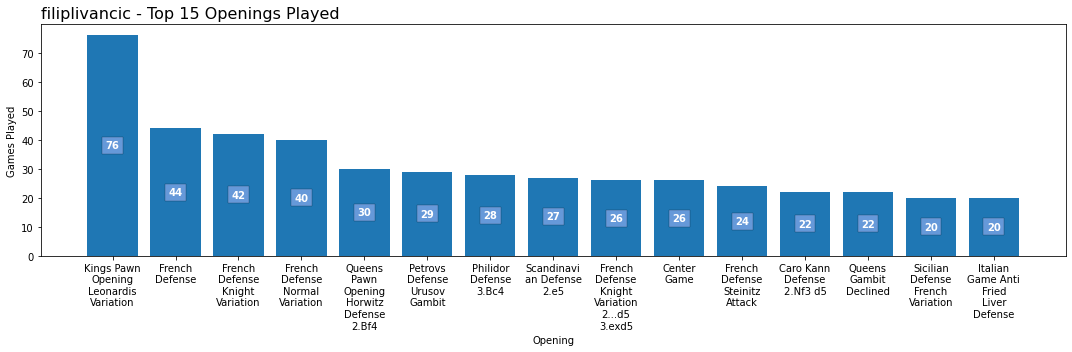

In [57]:
#Setting number of openings to display and wrapping text for readability
number_of_openings = 15
opening_name_newlines = ['\n'.join(wrap(open,10)) for i,open in enumerate(df_openings.index[0:number_of_openings])]
# opening_name_newlines = [('\n' if i % 2 == 1 else '') + opening_name_newlines[i]  for i in range(number_of_openings)] #KEEP IN CASE WE NEED TO ALTERNATE Y POSITION OF X-TICK

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(opening_name_newlines,df_openings['Games Played'].head(number_of_openings))
ax.set_title(f'{player} - Top {number_of_openings} Openings Played ',loc='left',fontsize=16)
ax.set_xlabel('Opening', fontsize = 10)
ax.set_ylabel('Games Played', fontsize=10)

# plt.subplots_adjust(bottom=0.25) #adjusting plot to prevent x-label cutoff
plt.tight_layout()

#Setting a backround color
fig.set_facecolor('white')

#Text Annotations
chart_annotation(df_openings[0:number_of_openings],'Games Played',ax,'bar')
plt.tight_layout()

plt.savefig('charts/top_openings.png',edgecolor='darkslategrey',dpi=150)

#### Game Result Split by Time of Day

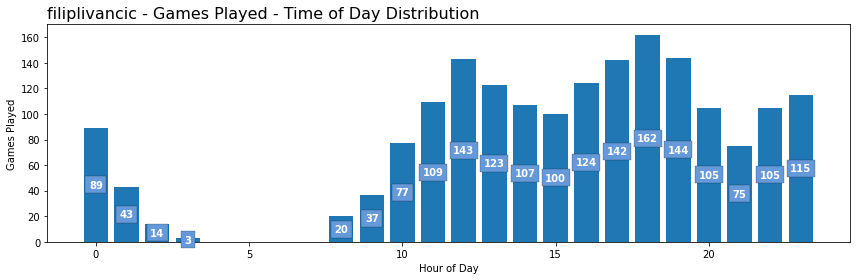

In [61]:
# Making a table with all the hours to eliminate discontinuity in dataset
hour_list = [i for i in range(24)]
hour_table = pd.DataFrame(hour_list,columns={'Hour'})

#Grouping data and performing right join to fill in potential gaps for the dims
df_time = df_blitz.groupby(['Hour'])['rated'].count().reset_index(name='Games')
df_time = pd.merge(df_time,hour_table,on='Hour',how='right')

fig, ax = plt.subplots(figsize=(12,4))
ax.bar(df_time['Hour'],df_time['Games'])
ax.set_title(f'{player} - Games Played - Time of Day Distribution',loc='left',fontsize=16)
ax.set_xlabel('Hour of Day', fontsize = 10)
ax.set_ylabel('Games Played', fontsize=10)
plt.tight_layout()

#Text Annotations
chart_annotation(df_time,'Games',ax,'bar')

plt.savefig('charts/time_of_day.png',edgecolor='darkslategrey',dpi=150)

#### Game Result Split by Day of Week

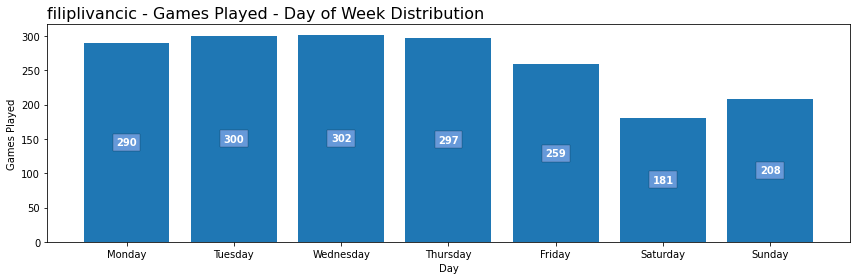

In [62]:
# Making a table with all the day names to eliminate discontinuity in dataset
dayName_list = [
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday'
]
dayName_table = pd.DataFrame(dayName_list,columns={'Day Name'})

#Grouping data and performing right join to fill in potential gaps for the dims
df_day_name = df_blitz.groupby(['Day Name'])['rated'].count().reset_index(name='Games')
df_day_name = pd.merge(df_day_name,dayName_table,on='Day Name',how='right')

fig, ax = plt.subplots(figsize=(12,4))
ax.bar(df_day_name['Day Name'],df_day_name['Games'])
ax.set_title(f'{player} - Games Played - Day of Week Distribution',loc='left',fontsize=16)
ax.set_xlabel('Day', fontsize = 10)
ax.set_ylabel('Games Played', fontsize=10)
plt.tight_layout()

#Text Annotations
chart_annotation(df_day_name,'Games',ax,'bar')

plt.savefig('charts/day_of_week.png',edgecolor='darkslategrey',dpi=150)

#### Volume of Activity

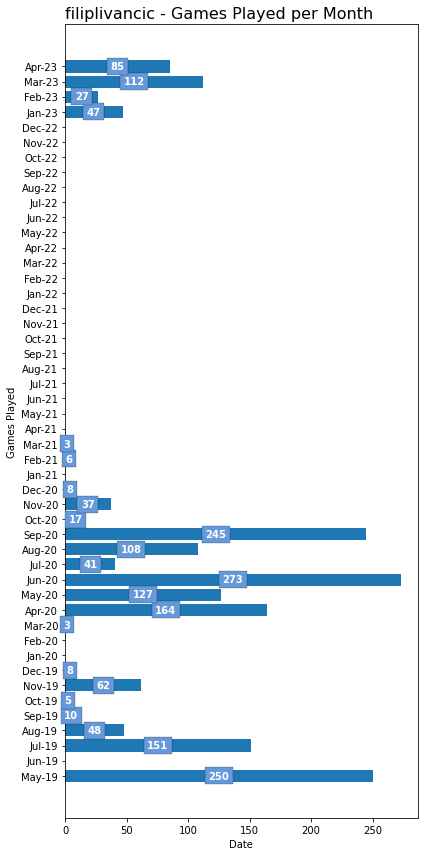

In [104]:
# Grouping Number of Games by Monthly Basis
df_activity = df_blitz.groupby(['Date'])['rated'].count()
df_activity = df_activity.groupby([pd.Grouper(level='Date',freq='M')]).sum().reset_index(name='Games')
for i in range(df_activity.shape[0]):
    df_activity.loc[i,'Date'] = df_activity.loc[i,'Date'].strftime("%b-%y")

fig, ax = plt.subplots(figsize=(6,12))
ax.barh(df_activity['Date'],df_activity['Games'])
ax.set_title(f'{player} - Games Played per Month',loc='left',fontsize=16)
ax.set_xlabel('Date', fontsize = 10)
ax.set_ylabel('Games Played', fontsize=10)
plt.tight_layout()

#Text Annotations
chart_annotation(df_activity,'Games',ax,'barh')

plt.savefig('charts/monthly_games.png',edgecolor='darkslategrey',dpi=150)

#### Game Result Summary

In [29]:
def pie_chart_maker(table,title,center_text,category,count,output_file):

    # Arranging Data Labels
    game_total = sum(table[count])
    result_labels = []
    for i in range(table.shape[0]):
        result = table.at[i,category]
        game_count = table.at[i,count]
        result_labels.append(f'{result}\n{game_count}')

    # Plotting Summary of Results
    fig, ax = plt.subplots(figsize=(5, 5), linewidth = 4 ,subplot_kw=dict(aspect="equal"))

    # Setting a backround color
    fig.set_facecolor('white')

    # Creating pie elements
    wedges, texts = ax.pie(table[count], wedgeprops=dict(width=0.5), startangle=-40)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="0", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    # Annotations
    ax.set_title(title,color='black',fontsize=13)
    ax.annotate(f'Games\n {center_text}:\n{game_total}', xy=(0, 0), xytext=(0, 0),
                horizontalalignment='center',fontsize = 10.5, **kw)

    # Creating Wedges
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(result_labels[i], xy=(x, y), xytext=(1.5*np.sign(x), 1.1*y),
                    horizontalalignment='center',fontsize = 9, **kw)

    plt.savefig(f'charts/{output_file}',edgecolor='darkslategrey',dpi=150)

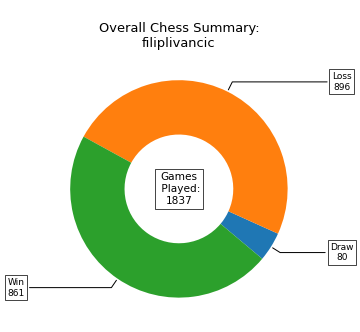

In [30]:
# Split by Game Result
table = df_blitz.groupby(['Game Result'])['rated'].count().reset_index(name='Games')
title = f'\nOverall Chess Summary:\n{player}'
center_text = 'Played'
category = 'Game Result'
count = 'Games'
output_file = 'chess_summary_pie.png'
pie_chart_maker(table,title,center_text,category,count,output_file)

In [31]:
# Split by End State
df_end_state_summary = df_blitz.groupby(['Game Result','End State'])['rated'].count().reset_index(name='Games')

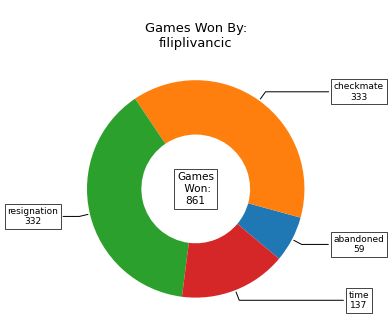

In [32]:
# Split by Winning End States
table = df_end_state_summary.loc[df_end_state_summary['Game Result']=='Win'].reset_index(drop=True)
title = f'\nGames Won By:\n{player}'
center_text = 'Won'
category = 'End State'
count = 'Games'
output_file = 'winning_end_pie.png'
pie_chart_maker(table,title,center_text,category,count,output_file)

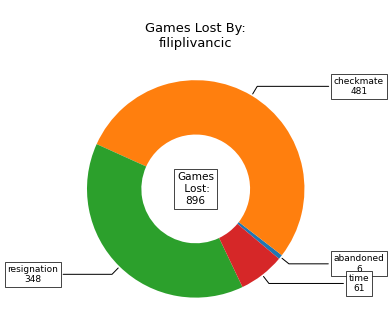

In [33]:
# Split by Losing End States
table = df_end_state_summary.loc[df_end_state_summary['Game Result']=='Loss'].reset_index(drop=True)
title = f'\nGames Lost By:\n{player}'
center_text = 'Lost'
category = 'End State'
count = 'Games'
output_file = 'losing_end_pie.png'
pie_chart_maker(table,title,center_text,category,count,output_file)

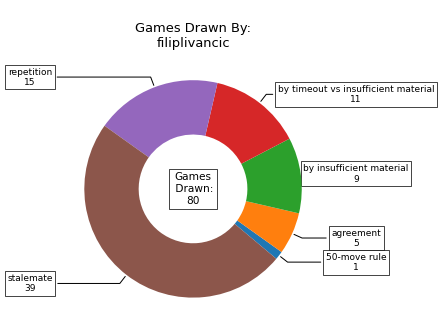

In [34]:
# Split by Drawn Status
table = df_end_state_summary.loc[df_end_state_summary['Game Result']=='Draw'].reset_index(drop=True)
title = f'\nGames Drawn By:\n{player}'
center_text = 'Drawn'
category = 'End State'
count = 'Games'
output_file = 'draw_end_pie.png'
pie_chart_maker(table,title,center_text,category,count,output_file)

# Plotting the Rating Change Over Time



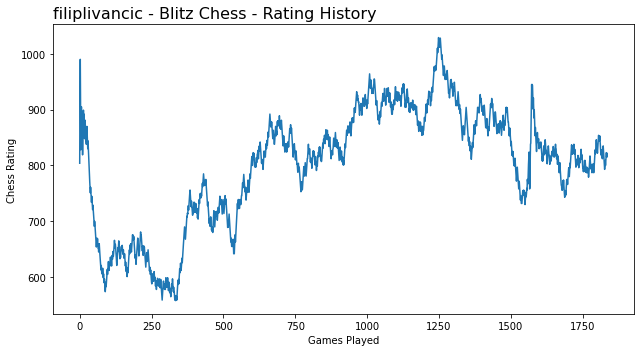

In [35]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(df_blitz.index,df_blitz['Player Rating'])
# ax.plot(df_blitz.index,df_blitz['Opponent Rating'])
ax.set_title(f'{player} - Blitz Chess - Rating History',loc='left',fontsize=16)
ax.set_xlabel('Games Played', fontsize = 10)
ax.set_ylabel('Chess Rating', fontsize=10)
plt.tight_layout()

plt.savefig(pathing('charts','raw_rating_line.png'),dpi=150)

## Applying a moving Average on the Rating Data

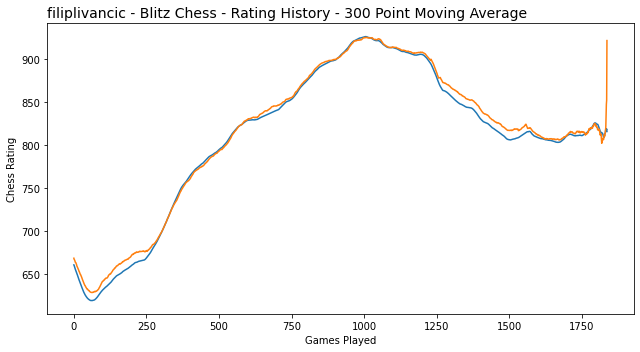

In [36]:
#Applying 100 point moving average
df_blitz_avg = df_blitz.copy()
window_size = 300
player_avg_data= []
opponent_avg_data= []
for i in range(df_blitz_avg.shape[0]):
    player_mov_avg = df_blitz_avg.loc[i:(i+window_size),'Player Rating'].mean()
    opponent_mov_avg = df_blitz_avg.loc[i:(i+window_size),'Opponent Rating'].mean()
    player_avg_data.append(player_mov_avg)
    opponent_avg_data.append(opponent_mov_avg)

#Appending list to dataframe
df_blitz_avg['Player Average Rating'] = player_avg_data
df_blitz_avg['Opponent Average Rating'] = opponent_avg_data

#Plotting Averaged Data
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(df_blitz_avg.index,df_blitz_avg['Player Average Rating'])
ax.plot(df_blitz_avg.index,df_blitz_avg['Opponent Average Rating'])
ax.set_title(f'{player} - Blitz Chess - Rating History - {window_size} Point Moving Average',loc='left',fontsize=14)
ax.set_xlabel('Games Played', fontsize = 10)
ax.set_ylabel('Chess Rating', fontsize=10)
plt.tight_layout()

plt.savefig(pathing('charts','avg_rating_line.png'),dpi=100)

## Initialising XlsxWriter Workbook And Exporting Tables to .xlsx

In [37]:
# #----------------------------------------------------------------------------------------------------------------------
# #--------------------------------------------.xlsx workbook initialisation---------------------------------------------
# #----------------------------------------------------------------------------------------------------------------------

# #Excel Output Filepath
# excelpath = pathing('xlsx_data','chess_data.xlsx')

# #Generating .xlsx workbook in which to record dataframes for usage.
# writer = pd.ExcelWriter(excelpath,engine='xlsxwriter')   
# workbook=writer.book
# worksheet='' #Initialise variable
# startrow = 0 #Initialise variable
# startcol = 0 #Initialise variable
# v_idx = 0    #initialise counter to index vertical chart insertions
# lr_pos = 0   #initialise left right insertion variable

# #----------------------------------------------------------------------------------------------------------------------
# #----------------------------------------------------------------------------------------------------------------------

In [38]:
# #Summary Table
# data_table = df_winLoss
# sheet_name = 'Summary'
# title_str = f'Chess Summary Stats - {player}'
# col_width_list = [20,20,20]
# [startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer)

In [39]:
# #Openings Table
# data_table = df_openings
# sheet_name = 'Openings'
# title_str = f'Chess Opening Count - {player}'
# col_width_list = [40,20,20]
# [startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer)

In [40]:
# #Results Table
# data_table = result_avg_df
# sheet_name = 'Rating History'
# title_str = f'Chess Rating History - {player}'
# col_width_list = [7,7,17,9,22,15]
# [startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer)

In [41]:
# #Save into Excel and Exit Python out of File
# writer.close()